In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading & Understanding Data
## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)

### Loading Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/features_3_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


### About the dataset

In [ ]:
print("Dataset has",df.shape)
print("Count of Positive and Negative samples")
df.label.value_counts().reset_index()

Dataset has (9990, 60)
Count of Positive and Negative samples


,index,label
0,blues,1000
1,jazz,1000
2,metal,1000
3,pop,1000
4,reggae,1000
5,disco,999
6,classical,998
7,hiphop,998
8,rock,998
9,country,997


# Data Visualization

In [ ]:
audio_fp = '/content/drive/MyDrive/Colab Notebooks/data/genres_original/blues/blues.00000.wav'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)

In [ ]:
# play sample file
IPython.display.Audio(audio_data, rate=sr)

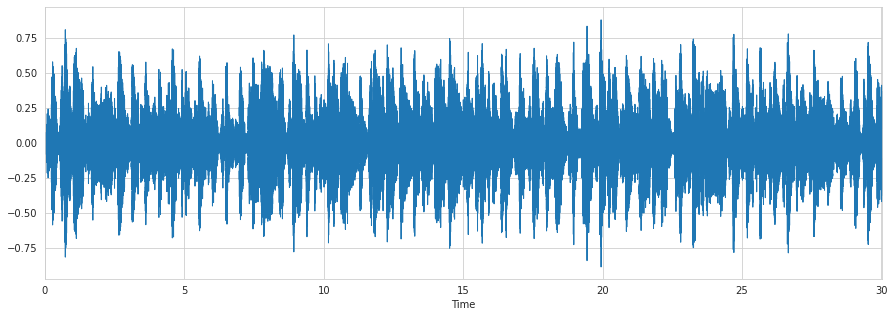

In [ ]:
# plot sample file
plt.figure(figsize=(15,5))
lplt.waveplot(audio_data)
plt.show()

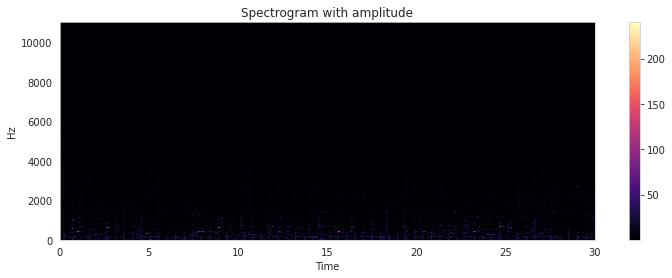

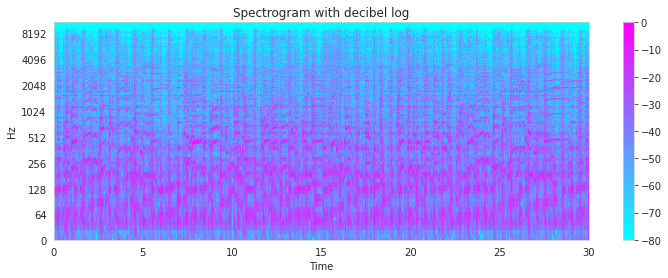

In [ ]:
# Default FFT window size
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT()

stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length) #Signal in t-f domain by computing dft over short overlapping windows
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()

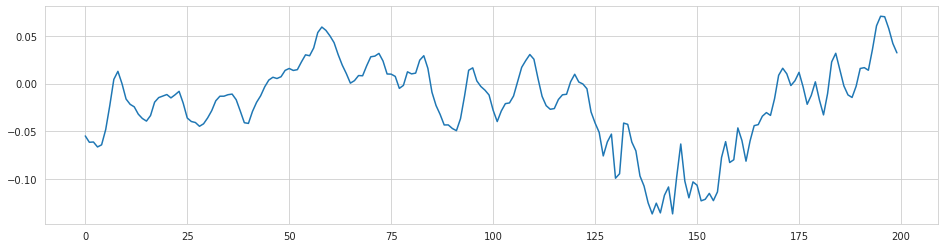

In [ ]:
# plot zoomed audio wave 
start = 1000
end = 1200
plt.figure(figsize=(16,4))
plt.plot(audio_data[start:end])
plt.show()

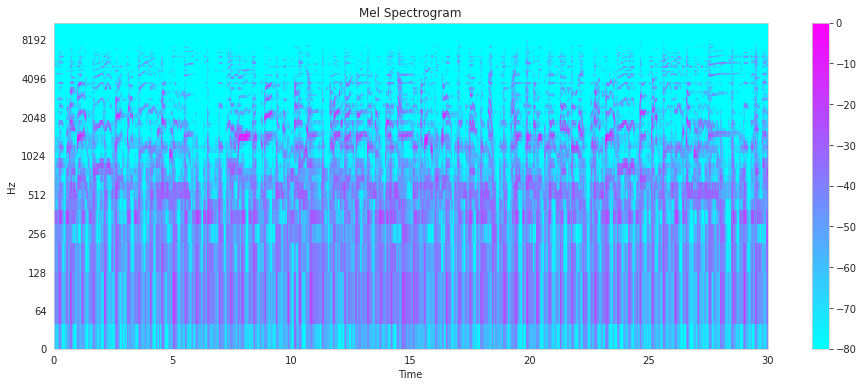

In [ ]:
#represents the waveform as percieved by the human ear
mel_spec = librosa.feature.melspectrogram(audio_data, sr=sr)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(16,6))
lplt.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.show()

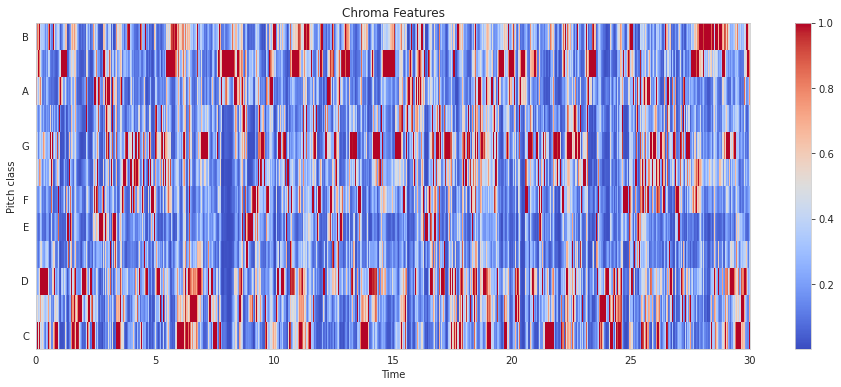

In [ ]:
#represents the tonal content of the audio signal in a condensed form
chroma = librosa.feature.chroma_stft(audio_data, sr=sr)
plt.figure(figsize=(16,6))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

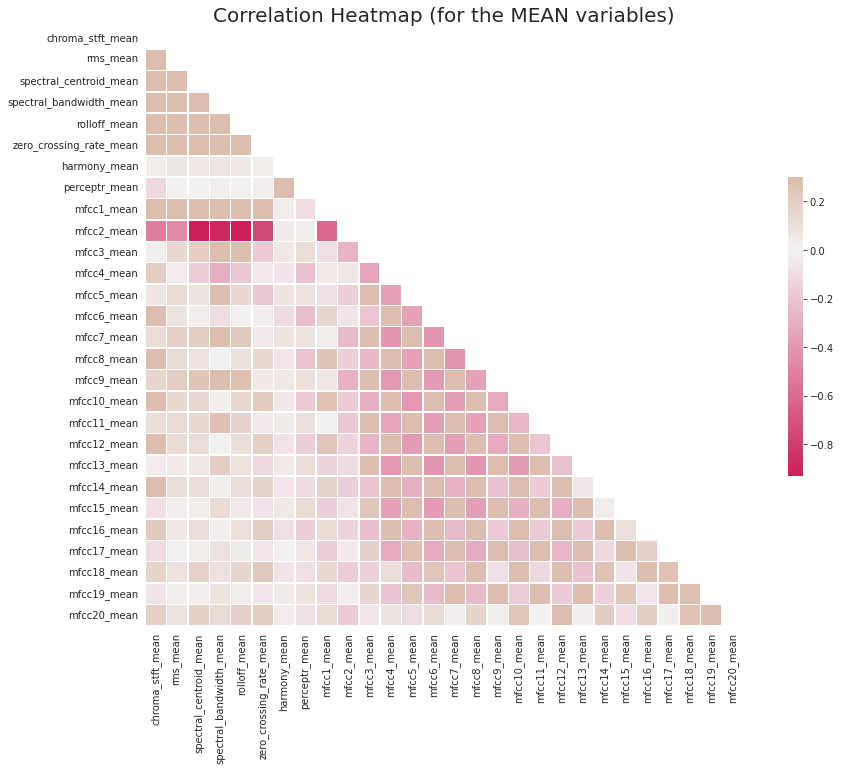

In [ ]:
# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr_Heatmap.png")

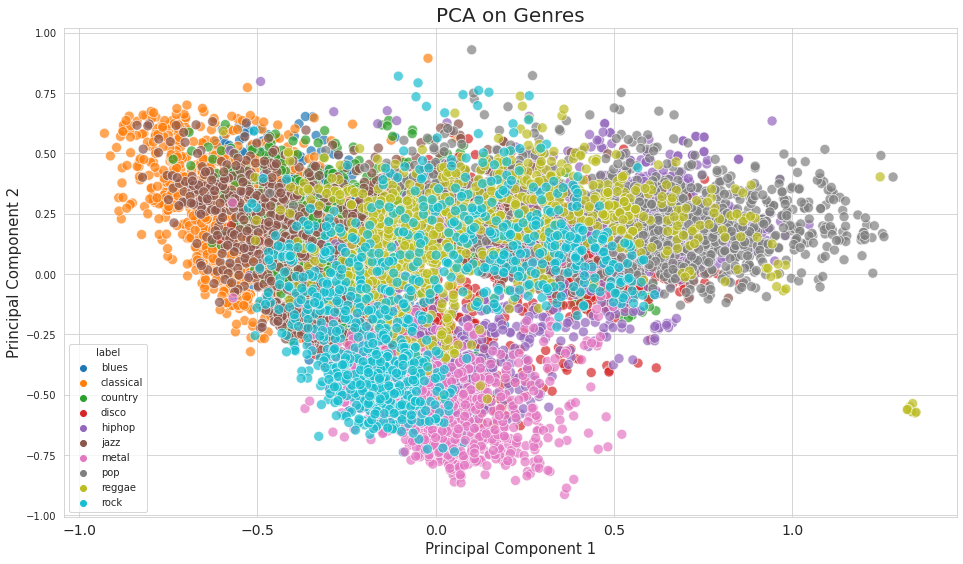

In [ ]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# Top 2 pca components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA_Scattert.png")

# Data Preparation

- Treat missing values.
- Outlier Treatment
- Define dummy variables for categorical variables.

## Missing Value Treatment

In [ ]:
# find all columns with any NA values
print("Columns with NA values are",list(df.columns[df.isnull().any()]))

Columns with NA values are []


## Encode Genre Label

In [ ]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [ ]:
# update labels in df to index
df.label = [label_index[l] for l in df.label]

# Split Train, Dev & Test Sets

In [ ]:
# shuffle samples
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [ ]:
# remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [ ]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%


In [ ]:
print(y_train.value_counts()[0]/y_train.shape[0]*100)
print(y_dev.value_counts()[0]/y_dev.shape[0]*100)
print(y_test.value_counts()[0]/y_test.shape[0]*100)

10.01001001001001
10.010111223458038
10.009813542688912


## Scale the Features

In [ ]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

# Deep Learning Model Building

In [ ]:
import tensorflow as tf
print("TF version:-", tf.__version__)
import keras as k
tf.random.set_seed(seed)

TF version:- 2.8.2


In [ ]:
ACCURACY_THRESHOLD = 0.94

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

def trainModel(model, epochs, optimizer):
    batch_size = 128
    callback = myCallback()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy'
    )
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, 
                     batch_size=batch_size, callbacks=[callback])

def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()


In [ ]:
model_1 = k.models.Sequential([
    k.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dense(10, activation='softmax'),
])
print(model_1.summary())
model_1_history = trainModel(model=model_1, epochs=70, optimizer='adam')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 256)               14848     
                                                                 
 dense_24 (Dense)            (None, 128)               32896     
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dense_26 (Dense)            (None, 10)                650       
                                                                 
Total params: 56,650
Trainable params: 56,650
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/70
55/55 [==============================] - 1s 6ms/step - loss: 1.4898 - accuracy: 0.4842 - val_loss: 1.0579 - val_accuracy: 0.6304
Epoch 2/70
55/55 [===================

Max. Validation Accuracy 0.8943377137184143


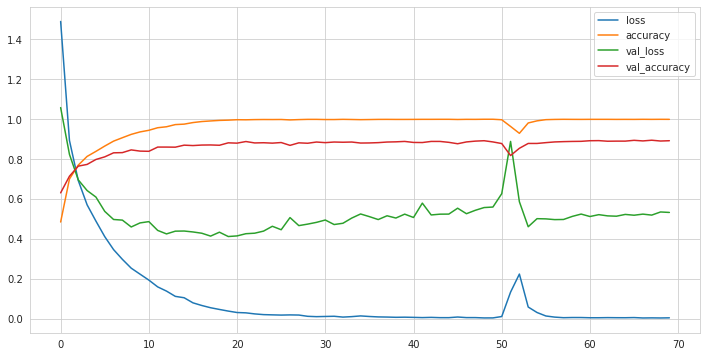

In [ ]:
plotHistory(model_1_history)

In [ ]:
model_2 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_2.summary())
model_2_history = trainModel(model=model_2, epochs=100, optimizer='adam')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               29696     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)               

In [ ]:
plotHistory(model_2_history)

In [ ]:
model_3 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_3.summary())
model_3_history = trainModel(model=model_3, epochs=70, optimizer='sgd')

In [ ]:
plotHistory(model_3_history)

In [ ]:
model_4 = k.models.Sequential([
    k.layers.Dense(1024, activation='selu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.3),
    
    k.layers.Dense(512, activation='selu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(256, activation='selu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(128, activation='selu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(64, activation='selu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(10, activation='sigmoid'),
])
print(model_4.summary())
model_4_history = trainModel(model=model_4, epochs=50, optimizer='rmsprop')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 1024)              59392     
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               524800    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 128)              

Max. Validation Accuracy 0.904448926448822


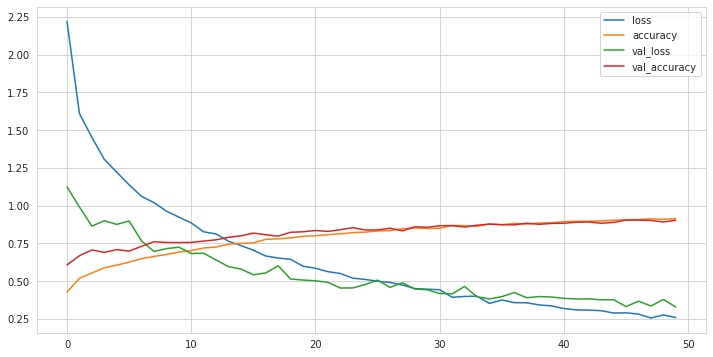

In [ ]:
plotHistory(model_4_history)

# Model Evaluation

In [ ]:
test_loss, test_acc  = model_4.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is :",test_loss)
print("\nThe Best test Accuracy is :",test_acc*100)

8/8 [==============================] - 0s 6ms/step - loss: 0.3250 - accuracy: 0.9087
The test Loss is : 0.3250281512737274

The Best test Accuracy is : 90.87340235710144


CUSTOM MODEL








In [ ]:
def custom_activation(x):
    return (K.sigmoid(x) * 5) - 1
def custom_l2_regularizer(weights):
    return tf.reduce_sum(0.02 * tf.square(weights))

In [ ]:
from keras import backend as K
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv1D, MaxPool1D
model_1 = Sequential()

model_1.add(Conv1D(filters=32, kernel_size=3, activation=custom_activation))
model_1.add(MaxPool1D(pool_size=2, strides=2))

model_1.add(Conv1D(filters=64, kernel_size=3, activation=custom_activation, padding = 'same'))
model_1.add(MaxPool1D(pool_size=2, strides=2))

model_1.add(Conv1D(filters=128, kernel_size=3, activation=custom_activation, padding = 'valid'))
model_1.add(MaxPool1D(pool_size=2, strides=2))

model_1.add(Flatten())

model_1.add(Dense(64,activation ="relu", kernel_regularizer=custom_l2_regularizer))
model_1.add(Dense(128,activation ="relu", kernel_regularizer=custom_l2_regularizer))
model_1.add(Dense(26,activation ="softmax"))

In [ ]:
from tensorflow.keras.optimizers import Adam
model_1.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history_1 = trainModel(model=model_4, epochs=50, optimizer='rmsprop')
#history_1 = model_1.fit(X_train, y_train, epochs=1,  validation_data = (X_test,y_test))

Epoch 1/50
55/55 [==============================] - 2s 27ms/step - loss: 0.2817 - accuracy: 0.9119 - val_loss: 0.3654 - val_accuracy: 0.8938
Epoch 2/50
55/55 [==============================] - 1s 25ms/step - loss: 0.2482 - accuracy: 0.9178 - val_loss: 0.3795 - val_accuracy: 0.8888
Epoch 3/50
55/55 [==============================] - 1s 26ms/step - loss: 0.2303 - accuracy: 0.9249 - val_loss: 0.3586 - val_accuracy: 0.9055
Epoch 4/50
55/55 [==============================] - 2s 41ms/step - loss: 0.2264 - accuracy: 0.9236 - val_loss: 0.3485 - val_accuracy: 0.9105
Epoch 5/50
55/55 [==============================] - 2s 37ms/step - loss: 0.2163 - accuracy: 0.9285 - val_loss: 0.3876 - val_accuracy: 0.9014
Epoch 6/50
55/55 [==============================] - 1s 25ms/step - loss: 0.1925 - accuracy: 0.9365 - val_loss: 0.3924 - val_accuracy: 0.9044
Epoch 7/50
55/55 [==============================] - 1s 26ms/step - loss: 0.2180 - accuracy: 0.9282 - val_loss: 0.4267 - val_accuracy: 0.8948
Epoch 8/50
55

In [ ]:
print("The validation accuracy is :", history_1.history['val_accuracy'])
print("The training accuracy is :", history_1.history['accuracy'])
print("The validation loss is :", history_1.history['val_loss'])
print("The training loss is :", history_1.history['loss'])

The validation accuracy is : [0.8938321471214294, 0.8887765407562256, 0.9054600596427917, 0.9105156660079956, 0.9014155864715576, 0.904448926448822, 0.8948432803153992, 0.9004044532775879, 0.9029322266578674, 0.9064711928367615, 0.9014155864715576, 0.9140545725822449, 0.9100100994110107, 0.9029322266578674, 0.917087972164154, 0.9145601391792297, 0.9135490655899048, 0.9160768389701843, 0.9130434989929199, 0.9074823260307312, 0.9069767594337463, 0.9054600596427917, 0.9095045328140259, 0.9095045328140259, 0.8948432803153992, 0.9100100994110107, 0.9150657057762146, 0.9100100994110107, 0.9115267992019653, 0.9201213121414185, 0.9150657057762146, 0.9079878926277161, 0.9009100198745728, 0.9095045328140259, 0.9145601391792297, 0.9120323657989502, 0.9049544930458069, 0.9084933996200562, 0.9029322266578674, 0.9105156660079956, 0.9135490655899048, 0.9135490655899048, 0.9206268787384033, 0.9175935387611389, 0.9201213121414185, 0.9191102385520935, 0.917087972164154, 0.917087972164154, 0.913549065589

In [ ]:
dict2={0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
predicted_values=pd.DataFrame(y_test)
predicted_values=predicted_values.replace({"label":dict2})
predicted_values.reset_index(drop=True, inplace=True)
predicted_values=list(predicted_values.label)
i=0
for item in predicted_values:
    print("The prediction of song no. {} in our dataset is {}".format(i,item))
    i=i+1
    

The prediction of song no. 0 in our dataset is metal
The prediction of song no. 1 in our dataset is jazz
The prediction of song no. 2 in our dataset is jazz
The prediction of song no. 3 in our dataset is classical
The prediction of song no. 4 in our dataset is metal
The prediction of song no. 5 in our dataset is jazz
The prediction of song no. 6 in our dataset is classical
The prediction of song no. 7 in our dataset is pop
The prediction of song no. 8 in our dataset is hiphop
The prediction of song no. 9 in our dataset is jazz
The prediction of song no. 10 in our dataset is metal
The prediction of song no. 11 in our dataset is rock
The prediction of song no. 12 in our dataset is pop
The prediction of song no. 13 in our dataset is jazz
The prediction of song no. 14 in our dataset is classical
The prediction of song no. 15 in our dataset is pop
The prediction of song no. 16 in our dataset is rock
The prediction of song no. 17 in our dataset is hiphop
The prediction of song no. 18 in our 

**Analysing Results**

In [ ]:
y_pred_test=predicted_values[1:500]
print("Out of first 500 Songs total Classical Songs are {}".format(y_pred_test.count('classical')))
print("Out of 500 Songs total Pop Songs are {}".format(y_pred_test.count('pop')))
print("Out of first 500 Songs total Disco Songs are {}".format(y_pred_test.count('disco')))
print("Out of first 500 Songs total Jazz Songs are {}".format(y_pred_test.count('jazz')))
print("Out of first 500 Songs total Metal Songs are {}".format(y_pred_test.count('metal')))
print("Out of first 500 Songs total Hiphop Songs are {}".format(y_pred_test.count('hiphop')))
print("Out of first 500 Songs total Rock Songs are {}".format(y_pred_test.count('rock')))
print("Out of first 500 Songs total Reggae Songs are {}".format(y_pred_test.count('reggae')))
print("Out of first 500 Songs total Blues Songs are {}".format(y_pred_test.count('blues')))
print("Out of first 500 Songs total Country Songs are {}".format(y_pred_test.count('country')))

Out of first 500 Songs total Classical Songs are 45
Out of 500 Songs total Pop Songs are 47
Out of first 500 Songs total Disco Songs are 53
Out of first 500 Songs total Jazz Songs are 47
Out of first 500 Songs total Metal Songs are 47
Out of first 500 Songs total Hiphop Songs are 48
Out of first 500 Songs total Rock Songs are 53
Out of first 500 Songs total Reggae Songs are 54
Out of first 500 Songs total Blues Songs are 59
Out of first 500 Songs total Country Songs are 46
